In [1]:
import torch
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms 
import numpy as np
from torch.utils.data import Dataset, DataLoader
import glob
from torch.autograd import Variable
from PIL import Image
from PIL import ImageChops
from PIL import ImageEnhance
import torch.optim as optim
import tqdm
import copy
import utils
import nyu_dataset
import pix2pix_model
import tqdm

/home/sasha/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
num_classes = 40

In [3]:
segmentation_dataset_train = nyu_dataset.SegmentationDataset(transforms=nyu_dataset.SegmentationTransform())
data_loader_train = DataLoader(segmentation_dataset_train, batch_size=8, shuffle=True, num_workers=1)

segmentation_dataset_validation = nyu_dataset.SegmentationDataset(path_to_datafolder='./datasets/nyu/val/', 
                                                                  transforms=
                                                                  nyu_dataset.SegmentationTransform(False))
data_loader_val = DataLoader(segmentation_dataset_validation, batch_size=1, shuffle=False, num_workers=1)

In [4]:
generator = pix2pix_model.Generator(num_classes, 3)
discriminator = pix2pix_model.Discriminator(num_classes + 3)

In [23]:
def train(data_loader_train, data_loader_val, generator, discriminator, num_epoch=100, lambda_param=10.0):
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    GANLoss = nn.BCELoss()
    L1Loss = nn.L1Loss()
    
    for epoch in tqdm.tqdm(range(num_epoch)):
        for image_batch, segmentation_batch in data_loader_train:
            image_batch = Variable(image_batch, requires_grad=False)
            segmentation_batch = Variable(segmentation_batch, requires_grad=False)
            
            fake_image_batch = generator.forward(segmentation_batch)
            
            # discriminator step
            d_optimizer.zero_grad()
            
            fake_input_discriminator = torch.cat((segmentation_batch, fake_image_batch), 1)
            real_input_discriminator = torch.cat((segmentation_batch, image_batch), 1)
            
            predictions_fake = discriminator.forward(fake_input_discriminator.detach())
            predictions_real = discriminator.forward(real_input_discriminator)
            
            target_tensor = Variable(torch.FloatTensor().fill_(1), requires_grad=False)
            loss_discriminator_real = GANLoss(predictions_real, target_tensor)
            
            target_tensor.data._fill(0)
            loss_discriminator_fake = GANLoss(predictions_fake, target_tensor)
            
            loss_discriminator = (loss_discriminator_fake + loss_discriminator_real)*0.5
            loss_discriminator.backward()
            d_optimizer.step()
            
            # generator step
            g_optimizer.zero_grad()
            
            fake_input_discriminator = torch.cat((segmentation_batch, fake_image_batch), 1)         
            predictions_fake = discriminator.forward(fake_input_discriminator)
            
            target_tensor.data._fill(1)
            loss_generator_gan = GANLoss(predictions_fake, target_tensor)
            
            loss_generator_L1 = L1Loss(fake_image_batch, image_batch)*lambda_param
            
            loss_generator = loss_generator_L1 + loss_generator_gan
            loss_generator.backward()
            g_optimizer.step()
        
        for image, segmentation in data_loader_val:
            segmentation = Variable(segmentation, requires_grad=False)   
            generated_image = generator.forward(segmentation)
            
            print('Val on epoch = {}'.format(epoch))
            plt.imshow(np.rollaxis(generated_image.data.numpy()[0], 0, 3))
            plt.show()
            break

  0%|          | 0/1 [00:00<?, ?it/s]

Val on epoch = 0
(256, 256, 3)


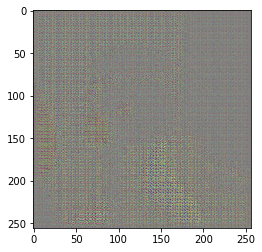

100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


In [24]:
train(data_loader_train, data_loader_val, generator, discriminator, num_epoch=1)